In [1]:
import pandas as pd
import numpy as np
import histlite as hl
import uproot as up

from matplotlib import pyplot as plt 

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams.update({'font.size': 18})
plt.rcParams["font.weight"] = 'light'
plt.rcParams["axes.labelweight"] = 'light'
plt.rcParams["font.family"] = ['Times New Roman']



In [2]:
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = (8,6)

# Implementing the Weisskopf formulas

In [3]:
hbar = 6.582119e-16 # eV*s
c = 2.99792458e8 * 1e15 # fm/s
alpha = 0.007297352
M_p = 938272088. # eV

def W_EL( energy, L, A ):

    k = energy / (hbar * c)
    factorial_term = np.prod( np.array([2 * L_temp + 1 for L_temp in range(L+1)]) ) # (2L + 1)!!
    kterm = k**(2*L+1) / hbar
    fraction_term = (8*np.pi*(L + 1)) / (L * factorial_term**2)
    
    return alpha*hbar*c * fraction_term * kterm / (4*np.pi) * \
            (3/(L+3))**2 * (1.2)**(2*L) * A**(2*L/3) 
    
    
def W_ML( energy, L, A ):
    
    k = energy / (hbar*c)
    kterm = k**(2*L+1) / hbar
    factorial_term = np.prod( np.array([2 * L_temp + 1 for L_temp in np.arange(L+1)]) ) # (2L + 1)!!
    fraction_term = (8*np.pi*(L + 1)) / (L * factorial_term**2) # (8pi(L+1))/(L*(2L+1)!!)^2
    magneton_term = (hbar/(2*M_p/c))**2 
    
    return alpha*hbar*c * magneton_term * fraction_term * kterm * 10 / np.pi *\
            (3/(L+3))**2 * (1.2)**(2*L-2) * A**((2*L-2)/3) 


## Cross-checking with reference data

Reference data taken from the following places:

https://inpp.ohio.edu/~meisel/PHYS7501/file/Lecture9_GammaDecay_PHYS7501_F2017_ZM.pdf

https://web1.eng.famu.fsu.edu/~dommelen/quansup/weis.pdf

In [4]:

m1_dig = np.genfromtxt('m1_digitized.csv',delimiter=',')
e1_dig = np.genfromtxt('e1_digitized.csv',delimiter=',')

3.1762744372906065e-08
3.176274437290608e-14


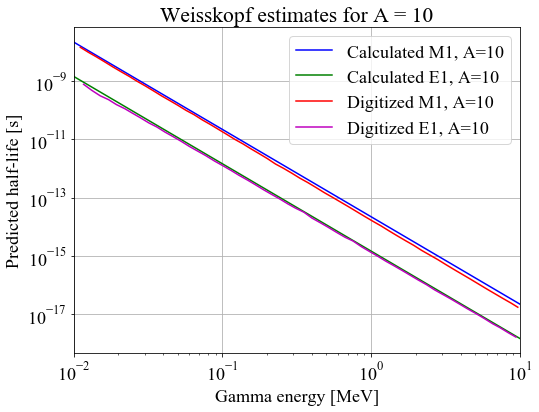

In [5]:
energies = np.logspace(-2.,1.,300)

M1 = W_ML(energies*1e6, 1, 10)
E1 = W_EL(energies*1e6, 1, 10)

plt.plot(energies, 1./M1 * np.log(2), '-b', label='Calculated M1, A=10' )
plt.plot(energies, 1./E1 * np.log(2), '-g', label='Calculated E1, A=10' )
plt.yscale('log')
plt.xscale('log')
# plt.ylim(1e-15,1)
plt.grid()
plt.xlim(0.01,10)
print(1./M1[0])
print(1/W_ML(1e6,1,10))
plt.plot(m1_dig[:,0],m1_dig[:,1],'-r',label='Digitized M1, A=10')
plt.plot(e1_dig[:,0],e1_dig[:,1],'-m',label='Digitized E1, A=10')
plt.legend()
plt.xlabel('Gamma energy [MeV]')
plt.ylabel('Predicted half-life [s]')
plt.title('Weisskopf estimates for A = 10')

plt.savefig('weisskopf_test.png',dpi=300,bbox_inches='tight')



0.003052264873467276


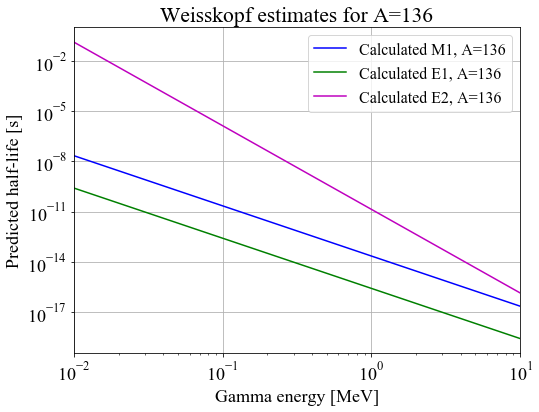

In [6]:
### energies = np.logspace(-2.,1.,300)

M1 = W_ML(energies*1e6, 1, 136)
E1 = W_EL(energies*1e6, 1, 136)
E2 = W_EL(energies*1e6, 2, 136)

plt.plot(energies, 1./M1 * np.log(2), '-b', label='Calculated M1, A=136' )
plt.plot(energies, 1./E1 * np.log(2), '-g', label='Calculated E1, A=136' )
plt.plot(energies, 1./E2 * np.log(2), '-m', label='Calculated E2, A=136' )
plt.yscale('log')
plt.xscale('log')
# plt.ylim(1e-15,1)
plt.grid()
plt.xlim(0.01,10)
plt.legend(fontsize=16)
plt.xlabel('Gamma energy [MeV]')
plt.ylabel('Predicted half-life [s]')
plt.title('Weisskopf estimates for A=136')

print(1./W_EL(2.3e4, 2, 136))


## Confirming that kr is less than 1, so we can use only the lowest-order multipoles 
Argument outlined in 'Introductory Nuclear Physics' by Wong

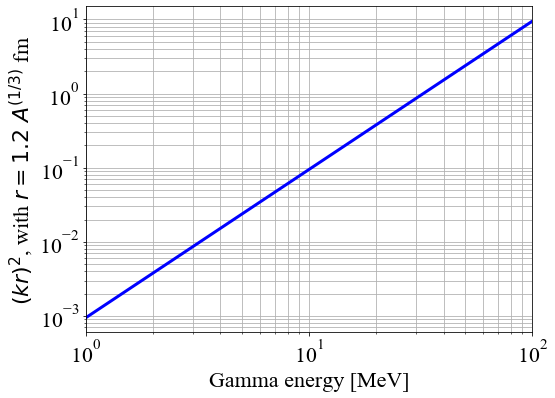

In [7]:
plt.rcParams['font.size'] = 22

# kr selection rules
A = 131
r = A**(1/3) * 1.2 # fm

hbar = 6.582119e-16 # eV*s
c = 3e8 * 1e15 # fm/s
energies = np.logspace(0.,2.,200) # MeV

k = (energies * 1e6) / (hbar * c)

plt.plot(energies,(k*r)**2, '-b',linewidth=3)
plt.xlabel('Gamma energy [MeV]')
plt.ylabel('$(kr)^2$, with $r = 1.2\,\,A^{(1/3)}$ fm')
plt.xlim(1.,100)
plt.xscale('log')
plt.yscale('log')
plt.grid(which='both')



# Working with the Capetown data

In [8]:
states = pd.read_csv('capetown_states.csv',delimiter=',')

In [9]:
states.head()

,Energy,Spin,Parity
0,0.0,5.0,1
1,72.0,4.0,1
2,102.0,4.0,1
3,137.0,3.0,-1
4,308.0,4.0,1


## Compute transition energies and probabilities

Here we assume that the lowest-order allowed multipoles will dominate the transition, so we only one each of E or M types.

Parity selection rules are accounted for.





In [10]:


e_transition_probs = []
m_transition_probs = []
transition_energies = []


i=0
for idx,irow in states.iterrows():
    e_transition_probs.append([])
    m_transition_probs.append([])
    transition_energies.append([])
    
    j=0
    for jdx,frow in states.iterrows():
        try:
            L = np.abs(int(frow['Spin']) - int(irow['Spin']))
            dE = float(irow['Energy']) - float(frow['Energy'])
    #         print('{} {} {}'.format(irow['Energy'],frow['Energy'],dE))

            if dE > 0.:
    #             print(int(frow['Parity']) * 2)
                if int(frow['Parity']) * int(irow['Parity']) == (-1)**L:
                    e_transition_probs[i].append( W_EL( dE * 1e3, L, 136))
                else:
                    e_transition_probs[i].append( 0. )

                if int(frow['Parity']) * int(irow['Parity']) == (-1)**(L+1):
                    m_transition_probs[i].append( W_ML(dE * 1e3, L, 136)) 
                else:
                    m_transition_probs[i].append( 0. )
                transition_energies[i].append( dE )
            else:
                e_transition_probs[i].append( 0. )
                m_transition_probs[i].append( 0. )
                transition_energies[i].append( 0. )
        except ValueError:
            e_transition_probs[i].append( 0. )
            m_transition_probs[i].append( 0. )
            dE = float(irow['Energy']) - float(frow['Energy'])
            if dE > 0.:
                transition_energies[i].append( dE )
            else:
                transition_energies[i].append( 0. )
        j += 1
            
    i += 1
            
e_transition_probs = np.array(e_transition_probs)
m_transition_probs = np.array(m_transition_probs)
transition_energies = np.array(transition_energies)
        

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars


In [11]:
transition_energies

array([[   0.,    0.,    0., ...,    0.,    0.,    0.],
       [  72.,    0.,    0., ...,    0.,    0.,    0.],
       [ 102.,   30.,    0., ...,    0.,    0.,    0.],
       ...,
       [2536., 2464., 2434., ...,    0.,    0.,    0.],
       [2555., 2483., 2453., ...,   19.,    0.,    0.],
       [2555., 2483., 2453., ...,   19.,    0.,    0.]])

In [12]:
# Create a DataFrame that contains all the possible transitions between states of different
# energies, as well as the electric and magnetic transition probabilities and initial/final data

transitions_dict_list = []

for i,energy_array in enumerate(transition_energies):
    for j,energy in enumerate(energy_array):
        transitions_dict_temp = {}
        
        transitions_dict_temp['Energy'] = energy
        transitions_dict_temp['M prob'] = m_transition_probs[i,j]
        transitions_dict_temp['E prob'] = e_transition_probs[i,j]
        transitions_dict_temp['Total prob'] = 0.
        if transitions_dict_temp['M prob'] != np.inf:
            transitions_dict_temp['Total prob'] += transitions_dict_temp['M prob']
        if transitions_dict_temp['E prob'] != np.inf:
            transitions_dict_temp['Total prob'] += transitions_dict_temp['E prob']
        transitions_dict_temp['Lifetime [s]'] = 1./transitions_dict_temp['Total prob']
        transitions_dict_temp['Rank'] = np.abs(states['Spin'].iloc[i] - states['Spin'].iloc[j])
        transitions_dict_temp['Initial energy'] = states['Energy'].iloc[i]
        transitions_dict_temp['Final energy'] = states['Energy'].iloc[j]
        transitions_dict_temp['Initial spin'] = states['Spin'].iloc[i]
        transitions_dict_temp['Final spin'] = states['Spin'].iloc[j]
        transitions_dict_temp['Initial parity'] = states['Parity'].iloc[i]
        transitions_dict_temp['Final parity'] = states['Parity'].iloc[j]
        
        
        transitions_dict_list.append( transitions_dict_temp )
        
transitions = pd.DataFrame(transitions_dict_list)
mask = (transitions['Energy'] != 0.)
transitions = transitions[mask]        

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars


In [13]:
transitions.head()

,Energy,M prob,E prob,Total prob,Lifetime [s],Rank,Initial energy,Final energy,Initial spin,Final spin,Initial parity,Final parity
100,72.0,1.175113e+10,0.000000e+00,1.175113e+10,8.509823e-11,1.0,72.0,0.0,4.0,5.0,1,1
200,102.0,3.341046e+10,0.000000e+00,3.341046e+10,2.993074e-11,1.0,102.0,0.0,4.0,5.0,1,1
201,30.0,0.000000e+00,inf,0.000000e+00,inf,0.0,102.0,72.0,4.0,4.0,1,1
300,137.0,2.849272e+04,0.000000e+00,2.849272e+04,3.509669e-05,2.0,137.0,0.0,3.0,5.0,-1,1
301,65.0,0.000000e+00,7.434084e+11,7.434084e+11,1.345156e-12,1.0,137.0,72.0,3.0,4.0,-1,1


## Compute the total transition probability and total lifetime of each state, from the table of transitions

In [14]:
# Compute the total transition probability and total lifetime of each state, 
# then append this to the "states" DataFrame

total_W_list = []

for idx, state in states.iterrows():
    transitions_mask = (transitions['Initial energy'] == state['Energy']) &\
                        (transitions['Initial spin'] == state['Spin']) & \
                        (transitions['Initial parity'] == state['Parity'])
    transitions_temp = transitions.loc[transitions_mask]
    good_mask = (transitions_temp['E prob'] == transitions_temp['E prob']) & \
                (transitions_temp['M prob'] == transitions_temp['M prob'])
    good_E_mask = (transitions_temp['E prob'] != np.inf)
    good_M_mask = (transitions_temp['M prob'] != np.inf)
    total_W = np.sum(transitions_temp['E prob'].loc[good_E_mask]) + \
                np.sum(transitions_temp['M prob'].loc[good_M_mask])
    total_W_list.append( total_W )
    
    
# print(len(total_W_list))
# print(len(states))
states['Total W'] = np.array(total_W_list)
states['Total Lifetime'] = 1./np.array( total_W_list )

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


In [15]:
# states.head(n=100)
transitions.head()
# states.head()

,Energy,M prob,E prob,Total prob,Lifetime [s],Rank,Initial energy,Final energy,Initial spin,Final spin,Initial parity,Final parity
100,72.0,1.175113e+10,0.000000e+00,1.175113e+10,8.509823e-11,1.0,72.0,0.0,4.0,5.0,1,1
200,102.0,3.341046e+10,0.000000e+00,3.341046e+10,2.993074e-11,1.0,102.0,0.0,4.0,5.0,1,1
201,30.0,0.000000e+00,inf,0.000000e+00,inf,0.0,102.0,72.0,4.0,4.0,1,1
300,137.0,2.849272e+04,0.000000e+00,2.849272e+04,3.509669e-05,2.0,137.0,0.0,3.0,5.0,-1,1
301,65.0,0.000000e+00,7.434084e+11,7.434084e+11,1.345156e-12,1.0,137.0,72.0,3.0,4.0,-1,1


In [16]:
states.head()

,Energy,Spin,Parity,Total W,Total Lifetime
0,0.0,5.0,1,0.000000e+00,inf
1,72.0,4.0,1,1.175113e+10,8.509823e-11
2,102.0,4.0,1,3.341046e+10,2.993074e-11
3,137.0,3.0,-1,8.594708e+11,1.163507e-12
4,308.0,4.0,1,1.445543e+13,6.917816e-14


## Compute branching fractions for each transition

In [17]:
# Compute branching fractions for each transition, using the total computed lifetimes of each state.

branching_fractions = []

for idx, transition in transitions.iterrows():
    states_mask = (states['Energy'] == transition['Initial energy']) &\
                    (states['Spin'] == transition['Initial spin']) &\
                    (states['Parity'] == transition['Initial parity'])
    state = states.loc[states_mask]
    if np.sum(states_mask) != 1:
        #print('ERROR {} at transition {}'.format(np.sum(states_mask),transition))
        #print('ERROR {}'.format(np.sum(states_mask)))
        branching_fractions.append(np.nan)
    else:
        W_total = state['Total W'].iloc[0]
        branching_fractions.append( transition['Total prob'] / W_total )
        
transitions['Branching fraction'] = np.array(branching_fractions)
    

## Add sub-tables of transitions with branching fractions to the "states" DataFrame

In [18]:
decay_branches = []

for idx, state in states.iterrows():
    transitions_mask = (state['Energy'] == transitions['Initial energy']) &\
                    (state['Spin'] == transitions['Initial spin']) &\
                    (state['Parity'] == transitions['Initial parity'])
    decay_branches.append( transitions.loc[transitions_mask] )
    
    
states['Decay scheme'] = decay_branches
    

In [19]:
# Example: let's show the decay scheme for state number 10
print(states.iloc[10])
states['Decay scheme'].iloc[10]

Energy                                                          651
Spin                                                              4
Parity                                                            1
Total W                                                 3.76287e+14
Total Lifetime                                          2.65754e-15
Decay scheme            Energy        M prob        E prob    To...
Name: 10, dtype: object


,Energy,M prob,E prob,Total prob,Lifetime [s],Rank,Initial energy,Final energy,Initial spin,Final spin,Initial parity,Final parity,Branching fraction
1000,651.0,8.686102e+12,0.000000e+00,8.686102e+12,1.151264e-13,1.0,651.0,0.0,4.0,5.0,1,1,2.308371e-02
1001,579.0,0.000000e+00,inf,0.000000e+00,inf,0.0,651.0,72.0,4.0,4.0,1,1,0.000000e+00
1002,549.0,0.000000e+00,inf,0.000000e+00,inf,0.0,651.0,102.0,4.0,4.0,1,1,0.000000e+00
1003,514.0,0.000000e+00,3.676010e+14,3.676010e+14,2.720341e-15,1.0,651.0,137.0,4.0,3.0,1,-1,9.769163e-01
1004,343.0,0.000000e+00,inf,0.000000e+00,inf,0.0,651.0,308.0,4.0,4.0,1,1,0.000000e+00
1005,233.0,0.000000e+00,inf,0.000000e+00,inf,0.0,651.0,418.0,4.0,4.0,1,1,0.000000e+00
1006,197.0,0.000000e+00,inf,0.000000e+00,inf,0.0,651.0,454.0,4.0,4.0,1,1,0.000000e+00
1007,141.0,1.328863e-09,0.000000e+00,1.328863e-09,7.525230e+08,4.0,651.0,510.0,4.0,8.0,1,-1,3.531513e-24
1008,69.0,5.408930e-05,0.000000e+00,5.408930e-05,1.848795e+04,3.0,651.0,582.0,4.0,1.0,1,1,1.437447e-19
1009,19.0,0.000000e+00,inf,0.000000e+00,inf,0.0,651.0,632.0,4.0,4.0,1,1,0.000000e+00


In [20]:
states.to_hdf('states_with_weisskopf_estimates.hd5',key='states')
transitions.to_hdf('transitions_with_weisskopf_estimates.hdf',key='transitions')

/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:2531: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['Parity', 'Decay scheme']]

  pytables.to_hdf(path_or_buf, key, self, **kwargs)
/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:2531: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['Initial parity', 'Final parity']]

  pytables.to_hdf(path_or_buf, key, self, **kwargs)


# Look at all transitions near ~74 keV to see if any transitions are expected to be long-lived and/or frequent


In [21]:
mask = (transitions['Energy'] > 68.) &\
        (transitions['Energy'] < 80.) &\
        (transitions['Total prob'] > 0.)

transitions.sort_values('Energy').loc[mask].head(n=100)

,Energy,M prob,E prob,Total prob,Lifetime [s],Rank,Initial energy,Final energy,Initial spin,Final spin,Initial parity,Final parity,Branching fraction
2319,69.0,0.000000e+00,7.939293e+04,7.939293e+04,1.259558e-05,2.0,1102.0,1033.0,5.0,3.0,1,1,3.196360e-10
1714,69.0,0.000000e+00,1.838888e-10,1.838888e-10,5.438068e+09,4.0,901.0,832.0,5.0,1.0,-1,-1,4.453072e-26
2419,69.0,0.000000e+00,4.650683e-03,4.650683e-03,2.150222e+02,3.0,1102.0,1033.0,6.0,3.0,-1,1,1.252817e-18
1008,69.0,5.408930e-05,0.000000e+00,5.408930e-05,1.848795e+04,3.0,651.0,582.0,4.0,1.0,1,1,1.437447e-19
2219,69.0,9.233715e+02,0.000000e+00,9.233715e+02,1.082988e-03,2.0,1102.0,1033.0,5.0,3.0,-1,1,1.005617e-13
6562,71.0,0.000000e+00,9.158580e+04,9.158580e+04,1.091872e-05,2.0,2083.0,2012.0,3.0,5.0,-1,-1,7.856383e-13
6563,71.0,0.000000e+00,5.680434e-03,5.680434e-03,1.760429e+02,3.0,2083.0,2012.0,3.0,6.0,-1,1,4.872771e-20
3532,72.0,0.000000e+00,9.821976e+04,9.821976e+04,1.018125e-05,2.0,1484.0,1412.0,4.0,2.0,1,1,9.936003e-12
7065,72.0,0.000000e+00,1.010380e+12,1.010380e+12,9.897264e-13,1.0,2155.0,2083.0,4.0,3.0,1,-1,1.799283e-05
3533,72.0,0.000000e+00,1.010380e+12,1.010380e+12,9.897264e-13,1.0,1484.0,1412.0,4.0,3.0,1,-1,1.022110e-04


In [22]:
transitions.sort_values('Branching fraction').loc[mask].head(n=100)

,Energy,M prob,E prob,Total prob,Lifetime [s],Rank,Initial energy,Final energy,Initial spin,Final spin,Initial parity,Final parity,Branching fraction
807,72.0,0.000000e+00,3.408536e-33,3.408536e-33,2.933811e+32,7.0,582.0,510.0,1.0,8.0,1,-1,3.308508e-40
2926,76.0,0.000000e+00,3.855331e-25,3.855331e-25,2.593811e+24,6.0,1262.0,1186.0,8.0,2.0,1,1,2.418266e-32
1714,69.0,0.000000e+00,1.838888e-10,1.838888e-10,5.438068e+09,4.0,901.0,832.0,5.0,1.0,-1,-1,4.453072e-26
2927,76.0,0.000000e+00,1.503533e-17,1.503533e-17,6.651003e+16,5.0,1262.0,1186.0,8.0,3.0,1,-1,9.430947e-25
2118,77.0,0.000000e+00,4.935488e-10,4.935488e-10,2.026142e+09,4.0,1063.0,986.0,6.0,2.0,1,1,6.406315e-24
6563,71.0,0.000000e+00,5.680434e-03,5.680434e-03,1.760429e+02,3.0,2083.0,2012.0,3.0,6.0,-1,1,4.872771e-20
1008,69.0,5.408930e-05,0.000000e+00,5.408930e-05,1.848795e+04,3.0,651.0,582.0,4.0,1.0,1,1,1.437447e-19
2419,69.0,0.000000e+00,4.650683e-03,4.650683e-03,2.150222e+02,3.0,1102.0,1033.0,6.0,3.0,-1,1,1.252817e-18
2018,77.0,0.000000e+00,1.002324e-02,1.002324e-02,9.976813e+01,3.0,1063.0,986.0,5.0,2.0,-1,1,1.258786e-18
2219,69.0,9.233715e+02,0.000000e+00,9.233715e+02,1.082988e-03,2.0,1102.0,1033.0,5.0,3.0,-1,1,1.005617e-13


In [23]:
transitions.sort_values('Lifetime [s]').loc[mask].head(n=100)

,Energy,M prob,E prob,Total prob,Lifetime [s],Rank,Initial energy,Final energy,Initial spin,Final spin,Initial parity,Final parity,Branching fraction
5350,78.0,0.000000e+00,1.284610e+12,1.284610e+12,7.784466e-13,1.0,1850.0,1772.0,4.0,5.0,1,-1,4.731556e-05
5653,78.0,0.000000e+00,1.284610e+12,1.284610e+12,7.784466e-13,1.0,1928.0,1850.0,3.0,4.0,-1,1,1.511177e-05
4843,78.0,0.000000e+00,1.284610e+12,1.284610e+12,7.784466e-13,1.0,1741.0,1663.0,3.0,4.0,-1,1,2.281353e-05
2827,76.0,0.000000e+00,1.188306e+12,1.188306e+12,8.415344e-13,1.0,1262.0,1186.0,2.0,3.0,1,-1,2.549910e-04
7772,72.0,0.000000e+00,1.010380e+12,1.010380e+12,9.897264e-13,1.0,2290.0,2218.0,2.0,3.0,1,-1,1.887182e-05
3533,72.0,0.000000e+00,1.010380e+12,1.010380e+12,9.897264e-13,1.0,1484.0,1412.0,4.0,3.0,1,-1,1.022110e-04
7065,72.0,0.000000e+00,1.010380e+12,1.010380e+12,9.897264e-13,1.0,2155.0,2083.0,4.0,3.0,1,-1,1.799283e-05
4743,78.0,1.494052e+10,0.000000e+00,1.494052e+10,6.693206e-11,1.0,1741.0,1663.0,3.0,4.0,1,1,4.275766e-06
8476,78.0,1.494052e+10,0.000000e+00,1.494052e+10,6.693206e-11,1.0,2368.0,2290.0,2.0,1.0,1,1,2.421771e-07
8377,78.0,1.494052e+10,0.000000e+00,1.494052e+10,6.693206e-11,1.0,2368.0,2290.0,1.0,2.0,1,1,5.718242e-05
